<a href="https://colab.research.google.com/github/SaNadira/multi-armed-bandint/blob/main/multi_armed_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import math
import random
from abc import ABC, abstractmethod
from typing import Dict

import matplotlib.pyplot as plt
from scipy.stats import uniform, norm

## Configs

In [ ]:
N_ARMS = 20
INITIAL_OBSERVATION_PER_ACTION = 10
EPSILON = 0.4
LEARNING_RATE = 0.001
NUMBER_OF_ITERATIONS = 1000000

# Configs for UCB
UCB_C = math.sqrt(2)

## Classes

### Environment

In [ ]:
class MultiArmedBandit:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.parameters = dict()
        for i in range(n_arms):
            mu = (uniform().rvs() * 2 - 1) / 10
            std = uniform().rvs() * 10
            self.parameters[i] = {
                "mu": mu,
                "std": std,
                "generator": norm(mu, std),
            }

        self.best_mu = max([x["mu"] for x in self.parameters.values()])

    def get_reward(self, action: int) -> float:
        assert action in list(range(self.n_arms)), print(action)
        return self.parameters[action]["generator"].rvs()

    def get_regret(self, action: int) -> float:
        assert action in list(range(self.n_arms)), print(action)
        return self.best_mu - self.parameters[action]["mu"]

### Agents

In [ ]:
class Agent(ABC):
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.total_regret_histroy = []

    @abstractmethod
    def policy(self) -> int:
        pass

    @abstractmethod
    def update(self, action: int, reward: float) -> None:
        pass

    def update_regret_history(self, regret: float) -> None:
        if len(self.total_regret_histroy) == 0:
            self.total_regret_histroy.append(regret)
        else:
            last_total_regret = self.total_regret_histroy[-1]
            self.total_regret_histroy.append(
                last_total_regret + regret
            )

In [ ]:
class GreedyAgent(Agent):
    def __init__(
        self,
        n_arms: int,
        initial_observation_per_action: int,
    ):
        super().__init__(n_arms=n_arms)
        self.initial_observation_per_action = initial_observation_per_action

        self.t = 0
        self.q = {
            action: {
                "count": 0,
                "estimated_q_value": 0,
            } for action in range(n_arms)
        }

    def policy(self) -> int:
        if self.t < self.initial_observation_per_action * self.n_arms:
            action = int(self.t / self.initial_observation_per_action)
            self.t += 1
            return action
        self.t += 1
        return max(
            list(self.q.keys()),
            key=lambda x: self.q[x]["estimated_q_value"],
        )

    def update(self, action: int, reward: float) -> None:
        assert action in list(self.q.keys())
        current_count = self.q[action]["count"]
        current_estimated_q_value = self.q[action]["estimated_q_value"]
        current_reward_sum = current_count * current_estimated_q_value

        new_estimated_q_value = (
            (current_reward_sum + reward)
            / (current_count + 1)
        )
        self.q[action]["count"] = current_count + 1
        self.q[action]["estimated_q_value"] = new_estimated_q_value

In [ ]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(
        self,
        n_arms: int,
        initial_observation_per_action: int,
        epsilon: float,
    ):
        super().__init__(
            n_arms=n_arms,
            initial_observation_per_action=initial_observation_per_action,
        )

        self.epsilon = epsilon
        self.uniform_generator = uniform()

    def policy(self) -> int:
        best_action = super().policy()
        if self.t < self.initial_observation_per_action * self.n_arms:
            return best_action

        random_number = self.uniform_generator.rvs()

        if random_number > self.epsilon:
            return best_action
        else:
            return random.choice(list(range(self.n_arms)))

In [ ]:
class PolicyGradientAgent(Agent):
    def __init__(
        self,
        n_arms: int,
        lr: float,
    ):
        super().__init__(n_arms=n_arms)
        self.lr = lr

        self.h = {
            x: 0 for x in range(n_arms)
        }

    @property
    def pi(self) -> Dict[int, float]:
        tmp_pi = {
            action: math.exp(self.h[action])
            for action in self.h.keys()
        }
        pi = dict()
        value_sum = sum([x for x in tmp_pi.values()])
        for action in tmp_pi.keys():
            pi[action] = tmp_pi[action] / value_sum
        return pi

    def policy(self) -> int:
        pi = self.pi
        return random.choices(
            list(range(self.n_arms)),
            [pi[x] for x in range(self.n_arms)],
            k=1,
        )[0]

    def update(self, action: int, reward: float) -> None:
        pi = self.pi
        for a in range(self.n_arms):
            if a == action:
                self.h[a] = self.h[a] + self.lr * reward * (1 - pi[a])
            else:
                self.h[a] = self.h[a] - self.lr * reward * pi[a]

In [ ]:
# Complete UCBAgent implementation
class UCBAgent(Agent):
    def __init__(self, n_arms: int, c: float = math.sqrt(2)):
        super().__init__(n_arms)
        self.c = c
        self.action_counts = {a: 0 for a in range(n_arms)}
        self.action_values = {a: 0.0 for a in range(n_arms)}
        self.total_steps = 0

    def policy(self) -> int:
        self.total_steps += 1

        # Initial exploration: try each arm at least once
        for action in range(self.n_arms):
            if self.action_counts[action] == 0:
                return action

        # Calculate UCB values for all arms
        ucb_values = {
            a: self.action_values[a] + self.c * math.sqrt(math.log(self.total_steps)/self.action_counts[a])
            for a in range(self.n_arms)
        }
        return max(ucb_values, key=lambda x: ucb_values[x])

    def update(self, action: int, reward: float) -> None:
        self.action_counts[action] += 1
        n = self.action_counts[action]
        self.action_values[action] += (reward - self.action_values[action]) / n

## Utils

In [ ]:
def play_game(
    env: MultiArmedBandit,
    agent: Agent,
    number_of_iterations: int = NUMBER_OF_ITERATIONS,
):
    for _ in range(number_of_iterations):
        action = agent.policy()
        reward = env.get_reward(action)
        regret = env.get_regret(action)
        agent.update(action=action, reward=reward)
        agent.update_regret_history(regret=regret)

## Play Game

In [ ]:
env = MultiArmedBandit(n_arms=N_ARMS)
greedy_agent = GreedyAgent(
    n_arms=N_ARMS,
    initial_observation_per_action=INITIAL_OBSERVATION_PER_ACTION,
)
epsilon_greedy_agent = EpsilonGreedyAgent(
    n_arms=N_ARMS,
    initial_observation_per_action=INITIAL_OBSERVATION_PER_ACTION,
    epsilon=EPSILON,
)
policy_gradient_agent = PolicyGradientAgent(
    n_arms=N_ARMS,
    lr=LEARNING_RATE,
)
ucb_agent = UCBAgent(
    n_arms=N_ARMS,
    c=math.sqrt(2)
)

In [ ]:
play_game(
    env=env,
    agent=greedy_agent,
)

play_game(
    env=env,
    agent=epsilon_greedy_agent,
)

play_game(
    env=env,
    agent=policy_gradient_agent,
)

play_game(
    env=env,
    agent=ucb_agent,
)

## Regret Analysis

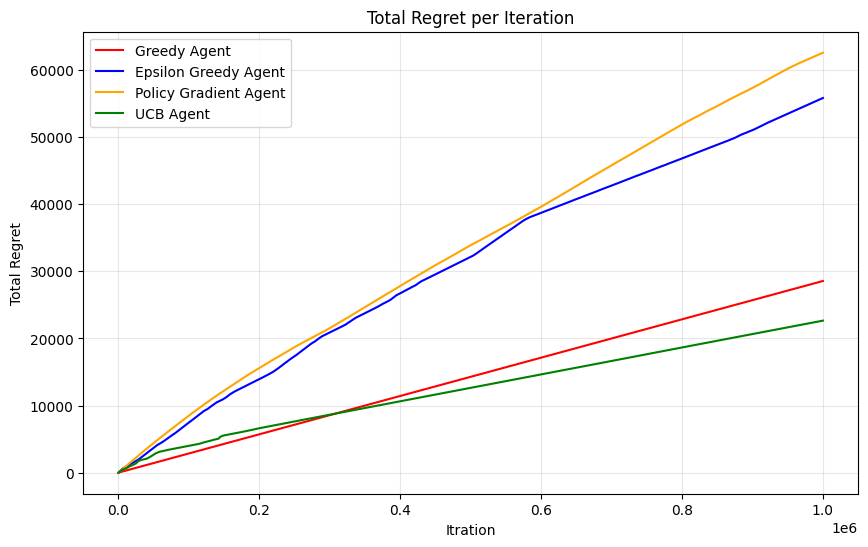

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    list(range(len(greedy_agent.total_regret_histroy))),
    greedy_agent.total_regret_histroy,
    label="Greedy Agent",
    color="red",
)

plt.plot(
    list(range(len(epsilon_greedy_agent.total_regret_histroy))),
    epsilon_greedy_agent.total_regret_histroy,
    label="Epsilon Greedy Agent",
    color="blue",
)

plt.plot(
    list(range(len(policy_gradient_agent.total_regret_histroy))),
    policy_gradient_agent.total_regret_histroy,
    label="Policy Gradient Agent",
    color="orange",
)

plt.plot(
    list(range(len(ucb_agent.total_regret_histroy))),
    ucb_agent.total_regret_histroy,
    label="UCB Agent",
    color="green",
)

plt.xlabel("Itration")
plt.ylabel("Total Regret")
plt.title("Total Regret per Iteration")
plt.grid(alpha=0.3)
plt.legend()
plt.show()